In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils.mea_analysis as mea
from sklearn.decomposition import PCA
import seaborn as sns
import re
import os

## Todo:

- implement functional channel removal on plotting and pca

 - work on annotating plot_pca_projection 
 
- look at attractive region with only good channels in pca plots

- try to do some cluster analysis on that

- add different colours for each channel for voltage plot

In [2]:
vdf = pd.read_csv("example_data/MEA002_postS_50V_V.csv",skiprows=22, sep="\t") #import 14-dimensional voltage data
smudf = pd.read_csv("example_data/MEA002_postS_50V_SMU.csv",skiprows=21, sep="\t") #import current/conductance data
filepath = "example_data/MEA002_postS_50V_SMU.csv"

In [3]:
vdf = vdf.drop(vdf.index[46000:])
smudf = smudf.drop(smudf.index[230:])

In [4]:
vcols = []
smucols = []

for header in list(vdf):
    header = header.replace("Voltage_", "v")
    header = header.replace("Untitled", "current")
    header = header.replace("X_Value", "time")
    vcols.append(header)
for header in list(smudf):
    header = header.replace("Untitled", "current")
    header = header.replace("X_Value", "time")
    smucols.append(header)
vdf.columns = vcols
smudf.columns = smucols

vdf["trel"] = vdf.time - vdf.time.iloc[0]
smudf["trel"] = smudf.time - smudf.time.iloc[0]

vdf.trel = pd.to_numeric(vdf.trel)
smudf.trel = pd.to_numeric(smudf.trel)

vdf = vdf.drop(['Comment'], axis=1)
smudf = smudf.drop(['Comment'], axis=1)

In [5]:
print(vdf.info())
print(smudf.info())
print(vdf.head())
print(smudf.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23000 entries, 0 to 22999
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    23000 non-null  float64
 1   v0      23000 non-null  float64
 2   v1      23000 non-null  float64
 3   v2      23000 non-null  float64
 4   v3      23000 non-null  float64
 5   v4      23000 non-null  float64
 6   v5      23000 non-null  float64
 7   v6      23000 non-null  float64
 8   v7      23000 non-null  float64
 9   v8      23000 non-null  float64
 10  v9      23000 non-null  float64
 11  v10     23000 non-null  float64
 12  v11     23000 non-null  float64
 13  v12     23000 non-null  float64
 14  v13     23000 non-null  float64
 15  v14     23000 non-null  float64
 16  v15     23000 non-null  float64
 17  trel    23000 non-null  float64
dtypes: float64(18)
memory usage: 3.3 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 0 to 229
Data columns (total 3 columns):
 

In [6]:
mea.open_data(filepath,smudf,vdf)

(     time   current  trel  voltage  conductance
 0    0.00  0.000387  0.00       50     0.099871
 1    0.01  0.000384  0.01       50     0.099097
 2    0.02  0.000348  0.02       50     0.089806
 3    0.03  0.000313  0.03       50     0.080774
 4    0.04  0.000298  0.04       50     0.076903
 ..    ...       ...   ...      ...          ...
 225  2.25  0.000362  2.25       50     0.093419
 226  2.26  0.000382  2.26       50     0.098581
 227  2.27  0.000329  2.27       50     0.084903
 228  2.28  0.000317  2.28       50     0.081806
 229  2.29  0.000244  2.29       50     0.062968
 
 [230 rows x 5 columns],
          time        v0         v1         v2        v3         v4         v5  \
 0       0.000  3.375491  -0.252188   0.240782  0.569880  -0.188390  -8.078901   
 1       0.001  3.363361  -0.251002   0.227517  0.556639  -0.187310  -8.076416   
 2       0.002  3.350614  -0.249758   0.213246  0.542328  -0.186162  -8.073895   
 3       0.003  3.338486  -0.248566   0.199379  0.528340 

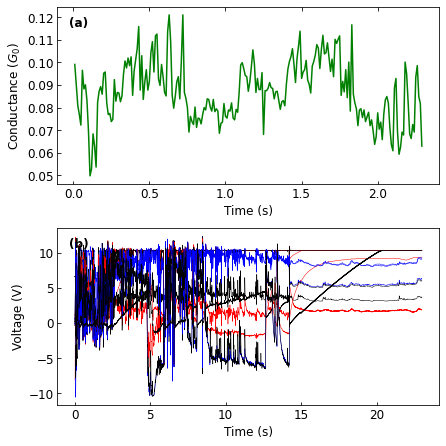

In [7]:
mea.plot_signal(vdf,smudf,show=True)

In [8]:
dg, iei =mea.analyze_events(smudf,gthresh=0.01)

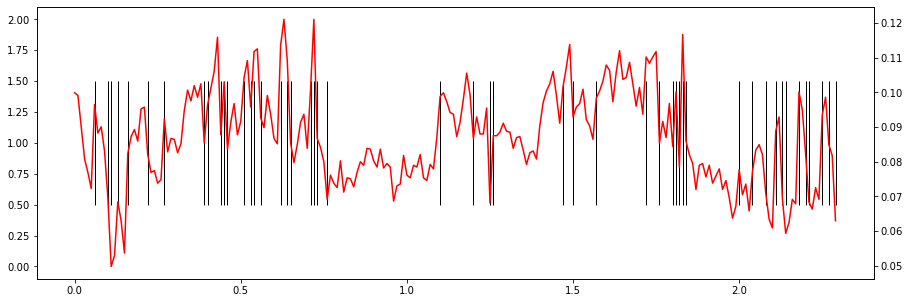

In [9]:
fig, ax = plt.subplots(nrows=1,figsize=(15,5))
ax.eventplot(dg[:,1],linewidth=1,color='k')
ax2=ax.twinx()
ax2.plot(smudf.trel,smudf.conductance,'r')

Text(0.5, 1.0, 'loglog interevent interval length histogram')

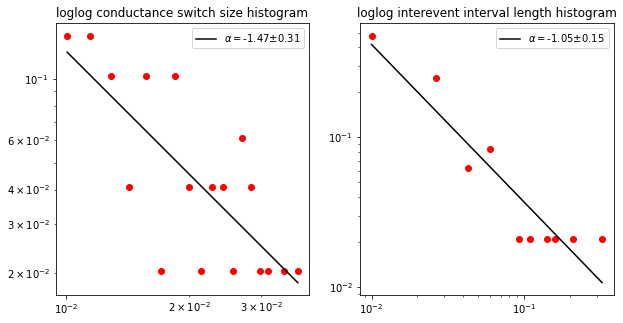

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
mea.plot_loglog(dg[:,0],axes[0])
mea.plot_loglog(iei,axes[1])
axes[0].set_title("loglog conductance switch size histogram")
axes[1].set_title("loglog interevent interval length histogram")

In [11]:
resd_all = vdf.iloc[:,3:-1].to_numpy()

In [12]:
print(resd_all.shape)
print(resd_all.ndim)
print(resd_all.size)

(23000, 14)
2
322000


In [13]:
for m in range(14):
    print(resd_all[2,m])

0.213246
0.5423279999999999
-0.186162
-8.073895
1.1680110000000001
-0.126891
-0.073719
-0.346453
0.605088
-0.083467
-0.317565
-0.289481
0.227255
6.62056


In [14]:
faulty_channels = [0] #removing unwanted voltage channels from PCA process
resd = np.delete(resd_all, faulty_channels, axis=1)

In [15]:
print(resd.shape)
print(resd.ndim)
print(resd.size)

(23000, 13)
2
299000


In [16]:
starttime = 10000 #start time of time-scale of interest in ms
endtime = 11000 #end time of time-scale of in in ms
resd = resd[starttime:endtime,:]

In [ ]:
mea.plot_principal_components(resd, faulty_channels, show = True, ends = True)
imgname = os.path.basename(filepath)[:-4]
plt.savefig(f"plots/{imgname}_{starttime/1000:0.0f}-{endtime/1000:0.0f}s.png")

### Manual PCA exploration

For neds ongoing python education: making a class and doing some stuff with methods and attributes

In [ ]:
class dog:
    def __init__(self, color): # this is a special method because of the __ or dunder method
        """ gets run whenever you make a new dog"""
        self.color = color #this sets color as the value for the attribute
        print(f"making a {self.color} dog")
        
    def bark(self): # this is a method, methods are functions that are attached to objects
        print(f"woof {self.color}")

In [ ]:
d = dog('black')
e = dog('white')
d.bark()
d.color='green'
d.bark()

In [17]:
# This step is VITAL for reasonable PCA. without some form of normalization pca is pretty odd.
# resd is the original data
# resd is an np array where each column is a dimension (voltage channel)
# and each row is a measurement of all dimensions (voltage at a time)
# normalise resd, to make PCA play nice
# can normalise in a number of ways, eg normalise by the whole dataset mean etc
resd = np.array([(point - point.mean()) / point.mean() for point in resd])

In [18]:


# from sklearn.decomposition import PCA
# instantiating a PCA oject
pca = PCA()


# perform the fit method of the pca object using our normalised data
pca.fit(resd)
# fit just refers to finding the pricipal components and score that "fit" your specific data (resd)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
pc = pca.components_ # attribute of the pca object after we have done fit

In [20]:
pc.shape # 14 by 14 (or n by n, where n is the total number of channels used) vector, with rows = components, and columns = number of dimensions of input data

(13, 13)

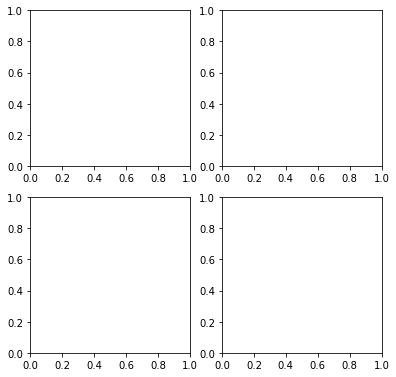

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6.3, 6.3))

In [22]:
# plots the relative variance that is due to each of the pc vectors
axes.flat[0].plot(pca.explained_variance_ratio_, "ro")
axes.flat[0].set_ylabel("relative variation ratio")
axes.flat[0].set_xlabel("principal component")

Text(0.5, 190.0007272727272, 'principal component')

### principal component channel removal

In [23]:
display_pc = np.insert(pc, faulty_channels, np.nan, axis=1)  # adds in empty values to allow 4x4 display of vectors

In [31]:
display_pc.shape # gives the size of the np array display_pc as a tuple

(13, 14)

In [25]:
vector_0 = np.insert(display_pc[0], [0, 14], np.nan).reshape((4, 4)) #places 1st principle component basis vector into a 4x4 array with nan at indices 0 and 14 (source and drain)
print(vector_0)
vector_1 = np.insert(display_pc[1], [0, 14], np.nan).reshape((4, 4)) #places 2nd principle component vector into a 4x4 array with nan at indices 0 and 14 (source and drain)
print(vector_1)
vrange_0 = np.nanmax(abs(vector_0))
print(vrange_0)
vrange_1 = np.nanmax(abs(vector_1))
print(vrange_1)

[[        nan         nan  0.1649072  -0.23422307]
 [-0.2508909  -0.05203116 -0.05785102 -0.24125186]
 [-0.24941428  0.31637274  0.27673235 -0.2444197 ]
 [-0.07968197  0.69559341 -0.04384175         nan]]
[[        nan         nan -0.51905389  0.24016077]
 [ 0.1305472  -0.04100492 -0.38511008  0.22185276]
 [ 0.17939956  0.04544236  0.36549193  0.04255806]
 [-0.5080127   0.1526045   0.07512444         nan]]
0.6955934085051564
0.5190538904836933


In [26]:
im_0 = axes.flat[1].imshow(vector_0, cmap="bwr", vmax=vrange_0, vmin=-vrange_0) #displays each component vector using a blue/white/red colour map with a range defined by vrange
im_1 = axes.flat[2].imshow(vector_1, cmap="bwr", vmax=vrange_1, vmin=-vrange_1) #"1" and "2" refer to the index of the image within the array of subplots, defined early when
                                                                                #"axes" was created  

In [29]:
axes.flat[1].axis("off") # turns off axes and axes values in the component vector displays
axes.flat[1].set_title(
    "$p_0 var$ = {:0.2f}".format(pca.explained_variance_ratio_[0]) #adds the percentage of variance this component vector accounts for as the title
)

Text(0.5, 1.0, '$p_0 var$ = 0.82')

In [30]:
axes.flat[2].axis("off")
axes.flat[2].set_title(
    "$p_1 var$ = {:0.2f}".format(pca.explained_variance_ratio_[1])
)

Text(0.5, 1.0, '$p_1 var$ = 0.10')

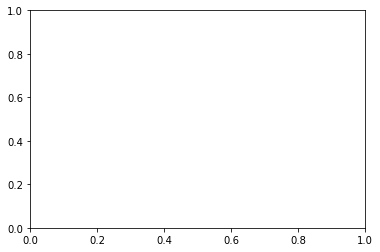

In [32]:
from mpl_toolkits.axes_grid1 import make_axes_locatable #package that allows colorbar to placed in a specific location

divider_0 = make_axes_locatable(axes.flat[0])                #returns instance of AxesLocator class, providing append_axes method, used to create a new axes for a component 
                                                             #vector grid
cax_0 = divider_0.append_axes("bottom", size="10%", pad=0.1) #cax is the axes into which the colorbar is drawn - cax axes is created below old axes, with width 0.1*axes and a
                                                             #distance of 0.1in between axes and cax
cb_0 = plt.colorbar(                                         
    im_0, cax=cax_0, orientation="horizontal", label="V", format="%.2f" #adds colorbar "cb" to plot, where im is the image descibed by the colorbar, cax is the new axes
)                                                                       #orientation=colorbar orientation, label=label on colorbar's long axis, format=no. decimal points on scale

divider_1 = make_axes_locatable(axes.flat[1])
cax_1 = divider_1.append_axes("bottom", size="10%", pad=0.1)
cb_1 = plt.colorbar(
    im_1, cax=cax_1, orientation="horizontal", label="V", format="%.2f"
)

In [33]:
cmin_0 = -vrange_0        # colorbar min value
cmax_0 = vrange_0         # colorbar max value
span_0 = cmax_0 - cmin_0  # colorbar range
        
cb_0.set_ticks([cmin_0 + (0.1 * span_0), cmax_0 - (0.1 * span_0)])
cb_0.set_ticklabels(
    ["{:.2f}".format(cmin_0 + (0.1 * span_0)), "{:.2f}".format(cmax_0 - (0.1 * span_0))]
)
cb_0.set_label("relative correlation")

cmin_1 = -vrange_1      
cmax_1 = vrange_1        
span_1 = cmax_1 - cmin_1
        
cb_1.set_ticks([cmin_1 + (0.1 * span_1), cmax_1 - (0.1 * span_1)])
cb_1.set_ticklabels(
    ["{:.2f}".format(cmin_1 + (0.1 * span_1)), "{:.2f}".format(cmax_1 - (0.1 * span_1))]
)
cb_1.set_label("relative correlation")

In [41]:
plot_pca_projection 

NameError: name 'plot_pca_projection' is not defined

#### principal component manual exploration

In [ ]:
# first 14-d (n-d) normalised vector
resd[0]

In [ ]:
# first two principal component vectors.
# eg. 0th row, all columns = [0,:] etc.
pc1 = pc[0, :]
pc2 = pc[1, :]

In [ ]:
# projection of the first normalized vector of original vector onto first and second pc. 
# to what extent is this vector represented by each pc
resd[0].dot(pc1), resd[0].dot(pc2)

In [ ]:
# matrix multiplication of the first two pc vectors with the first data vector
resd[0].dot(pc[:2,:].T)

In [ ]:
# doing the matrix mult, with the first two pc, and the whole matrix of (n, 14) resd matrix
# (n, 14).(14,2) -> (n,2)
projection = resd.dot(pc[:2,:].T)

In [ ]:
plt.scatter(projection[:,0], projection[:,1], alpha=0.2)
# plt.xlim((0,200))
# plt.ylim((-10,59))

In [ ]:
sns.kdeplot(projection[:,0], projection[:,1], shade=True)